# Mac Mobile

This is where we will conduct the machine learning experimentation to develop and train an accurate model for classifying when users are standing, sitting, etc.

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import pandas as pd

#Load accelerometer data
display("Accelerometer data")
accelerometer_csv = pd.read_csv("/content/drive/My Drive/macmobile_data/Sample Data_Accelerometer_2018-07-31T16-03-06.231.csv")
display(accelerometer_csv.head(10))

#Load ambient light data
#display("Light data")
#ambient_light_csv = pd.read_csv("/content/drive/My Drive/macmobile_data/Sample Data_Ambient Light_2018-07-31T16-03-06.231.csv")
#display(ambient_light_csv.head(10))

#Load gyroscope data
display("Gyroscope data")
gyroscope_csv = pd.read_csv("/content/drive/My Drive/macmobile_data/Sample Data_Gyroscope_2018-07-31T16-03-06.231.csv")
display(gyroscope_csv.head(10))

#Load magnetometer data
#display("Magnetometer data")
#magnetometer_csv = pd.read_csv("/content/drive/My Drive/macmobile_data/Sample Data_Magnetometer_2018-07-31T16-03-06.231.csv")
#display(magnetometer_csv.head(10))

#Load pressure data
#display("Pressure data")
#pressure_csv = pd.read_csv("/content/drive/My Drive/macmobile_data/Sample Data_Pressure_2018-07-31T16-03-06.231.csv")
#display(pressure_csv.head(10))

#Load temperature data
#display("Temperature data")
#temperature_csv = pd.read_csv("/content/drive/My Drive/macmobile_data/Sample Data_Temperature_2018-07-31T16-03-06.231.csv")
#display(temperature_csv.head(10))

'Accelerometer data'

,epoch (ms),time (-07:00),elapsed (s),X-Axis (g),Y-Axis (g),Z-Axis (g)
0,1533078186498,2018-07-31T16:03:06.498,0.000,-0.311,-0.192,0.936
1,1533078186498,2018-07-31T16:03:06.498,0.000,-0.315,-0.195,0.942
2,1533078186498,2018-07-31T16:03:06.498,0.000,-0.316,-0.192,0.941
3,1533078186618,2018-07-31T16:03:06.618,0.120,-0.314,-0.193,0.943
4,1533078186618,2018-07-31T16:03:06.618,0.120,-0.313,-0.192,0.943
5,1533078186618,2018-07-31T16:03:06.618,0.120,-0.314,-0.193,0.944
6,1533078186738,2018-07-31T16:03:06.738,0.240,-0.313,-0.190,0.946
7,1533078186738,2018-07-31T16:03:06.738,0.240,-0.301,-0.200,0.945
8,1533078186738,2018-07-31T16:03:06.738,0.240,-0.292,-0.204,0.947
9,1533078186859,2018-07-31T16:03:06.859,0.361,-0.341,-0.205,0.931


'Gyroscope data'

,epoch (ms),time (-07:00),elapsed (s),X-Axis (°/s),Y-Axis (°/s),Z-Axis (°/s)
0,1533078186408,2018-07-31T16:03:06.408,0.00,0.427,2.134,-0.366
1,1533078186408,2018-07-31T16:03:06.408,0.00,0.488,1.951,-0.244
2,1533078186408,2018-07-31T16:03:06.408,0.00,-1.280,1.890,-0.366
3,1533078186528,2018-07-31T16:03:06.528,0.12,-1.768,1.951,-0.122
4,1533078186528,2018-07-31T16:03:06.528,0.12,1.768,2.500,-0.732
5,1533078186528,2018-07-31T16:03:06.528,0.12,0.000,2.256,-0.732
6,1533078186678,2018-07-31T16:03:06.678,0.27,-0.427,2.195,-0.427
7,1533078186678,2018-07-31T16:03:06.678,0.27,-0.244,2.256,-0.488
8,1533078186678,2018-07-31T16:03:06.678,0.27,-0.976,2.073,-0.488
9,1533078186828,2018-07-31T16:03:06.828,0.42,-10.671,-0.793,1.951


In [0]:
import sys
def windowify(size, step, dataset, stats_func):
  # Get the first timestamp
  start = dataset['epoch (ms)'].iloc[0]
  
  #index of the starting timestamp
  start_index = 0
  
  #index of the beginning of the next step
  step_index = 0
  
  #current index
  i = 0
  
  #stores all the windows
  windows = []
  
  #length of the dataset
  dataset_length = dataset['epoch (ms)'].count()
  
  while i < dataset_length:
    optimal_step = start + step
    min_step_distance = sys.maxsize
    #while we haven't reached the end of the dataset and we still have no completed an entire window
    while i < dataset_length and start + size >= dataset['epoch (ms)'].iloc[i]:
      
      #Find the closest entry to where the step _would_ be
      if abs(optimal_step - dataset['epoch (ms)'].iloc[i]) < min_step_distance:
        step_index = i
        min_step_distance = abs(optimal_step - dataset['epoch (ms)'].iloc[i])
      i += 1
    
    #we have a window of duration size that starts at index start_index and ends at i
    window_frame = dataset[start_index:i]
    
    #calculate some information about the window and store it
    windows.append(stats_func(window_frame))
    
    if i == dataset_length:
      break
    #start the next window
    start_index = step_index
    i = step_index
    start = dataset['epoch (ms)'].iloc[start_index]
    
  return windows

User actions are defined as follows:


*   0: Sitting
*   1: Laying in bed
*   2: Walking
*   3: Standing



In [0]:
from random import randint

def accelerometer_stats(window_frame):
  return {
      "x_avg": window_frame["X-Axis (g)"].mean(),
      "x_max": window_frame["X-Axis (g)"].max(),
      "x_min": window_frame["X-Axis (g)"].min(),
      "x_var": window_frame["X-Axis (g)"].var(),
      
      "y_avg": window_frame["Y-Axis (g)"].mean(),
      "y_max": window_frame["Y-Axis (g)"].max(),
      "y_min": window_frame["Y-Axis (g)"].min(),
      "y_var": window_frame["Y-Axis (g)"].var(),
      
      "z_avg": window_frame["Z-Axis (g)"].mean(),
      "z_max": window_frame["Z-Axis (g)"].max(),
      "z_min": window_frame["Z-Axis (g)"].min(),
      "z_var": window_frame["Z-Axis (g)"].var(),
      
      "epoch_start": window_frame["epoch (ms)"].min(),
      "epoch_end": window_frame["epoch (ms)"].max(),
      "epoch_length": window_frame["epoch (ms)"].max() - window_frame["epoch (ms)"].min(),
      
      # For now we randomly assign an action the user is doing until we can capture and label our own data
      "action": randint(0,3)
  }

def gyroscope_stats(window_frame):
  return {
      "x_avg": window_frame["X-Axis (°/s)"].mean(),
      "x_max": window_frame["X-Axis (°/s)"].max(),
      "x_min": window_frame["X-Axis (°/s)"].min(),
      "x_var": window_frame["X-Axis (°/s)"].var(),
      
      "y_avg": window_frame["Y-Axis (°/s)"].mean(),
      "y_max": window_frame["Y-Axis (°/s)"].max(),
      "y_min": window_frame["Y-Axis (°/s)"].min(),
      "y_var": window_frame["Y-Axis (°/s)"].var(),
      
      "z_avg": window_frame["Z-Axis (°/s)"].mean(),
      "z_max": window_frame["Z-Axis (°/s)"].max(),
      "z_min": window_frame["Z-Axis (°/s)"].min(),
      "z_var": window_frame["z-Axis (°/s)"].var(),
      
      "epoch_start": window_frame["epoch (ms)"].min(),
      "epoch_end": window_frame["epoch (ms)"].max(),
      "epoch_length": window_frame["epoch (ms)"].max() - window_frame["epoch (ms)"].min(),
      
      # For now we randomly assign an action the user is doing until we can capture and label our own data
      "action": randint(0,3)
  }

In [13]:
accelerometer_windows = windowify(2500, 1000, accelerometer_csv, accelerometer_stats)
accelerometer_dataframe = pd.DataFrame.from_records(accelerometer_windows)
display(accelerometer_dataframe)

,action,epoch_end,epoch_length,epoch_start,x_avg,x_max,x_min,x_var,y_avg,y_max,y_min,y_var,z_avg,z_max,z_min,z_var
0,3,1533078188928,2430,1533078186498,-0.316905,-0.175,-0.485,8.230230e-04,-0.176746,-0.079,-0.205,0.000302,0.954079,1.233,0.931,1.888268e-03
1,1,1533078189918,2430,1533078187488,-0.254873,0.051,-0.523,2.151695e-02,-0.152095,0.004,-0.359,0.004364,0.968730,2.148,0.206,1.817113e-01
2,2,1533078190878,2430,1533078188448,0.023270,2.010,-1.028,2.956499e-01,-0.171317,1.438,-1.311,0.182593,0.744127,2.524,-2.315,1.283170e+00
3,1,1533078191868,2430,1533078189438,0.332698,2.010,-1.393,5.503576e-01,-0.182143,1.438,-1.311,0.309104,0.441937,2.524,-2.315,1.823869e+00
4,2,1533078192858,2460,1533078190398,0.186698,2.010,-1.393,6.481781e-01,-0.144365,1.438,-1.222,0.253055,0.436333,2.524,-2.315,1.635807e+00
5,1,1533078193818,2430,1533078191388,-0.169286,1.969,-1.393,3.147971e-01,-0.206365,0.496,-0.712,0.040696,0.747698,2.269,-1.089,2.449632e-01
6,1,1533078194808,2459,1533078192349,-0.391921,-0.389,-0.396,2.880696e-06,-0.175968,-0.164,-0.202,0.000108,0.917111,0.920,0.913,1.681004e-06
7,0,1533078195768,2430,1533078193338,-0.392857,-0.389,-0.396,1.834101e-06,-0.166778,-0.161,-0.177,0.000017,0.917968,0.920,0.915,8.699437e-07
8,2,1533078196758,2460,1533078194298,-0.393397,-0.391,-0.396,7.270865e-07,-0.162746,-0.159,-0.168,0.000006,0.918270,0.920,0.917,8.131080e-07
9,3,1533078197718,2430,1533078195288,-0.393635,-0.392,-0.397,8.161802e-07,-0.160460,-0.157,-0.165,0.000003,0.918492,0.921,0.917,8.346134e-07


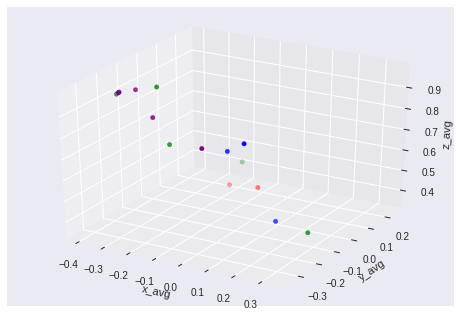

In [14]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors = ['red','green','blue','purple']
color_labels = ['sitting', 'laying in bed', 'walking', 'standing']

ax.scatter(xs=accelerometer_dataframe['x_avg'],
           ys=accelerometer_dataframe['y_avg'],
           zs=accelerometer_dataframe['z_avg'],
           c=accelerometer_dataframe['action'],
           cmap=matplotlib.colors.ListedColormap(colors))

ax.set_xlabel('x_avg')
ax.set_ylabel('y_avg')
ax.set_zlabel('z_avg')

plt.show()

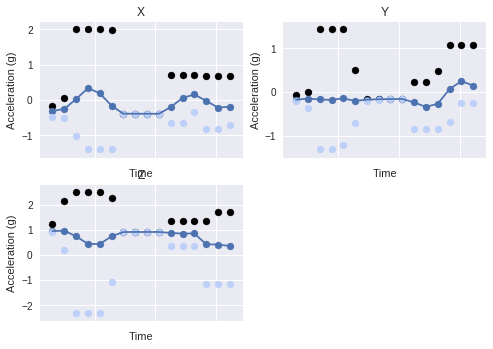

In [15]:
fig = plt.figure()
ax = fig.add_subplot(221)
ay = fig.add_subplot(222)
az = fig.add_subplot(223)

ax.scatter(accelerometer_dataframe['epoch_start'], accelerometer_dataframe['x_max'],c="#000000")
ax.scatter(accelerometer_dataframe['epoch_start'], accelerometer_dataframe['x_avg'])
ax.plot(accelerometer_dataframe['epoch_start'], accelerometer_dataframe['x_avg'])
ax.scatter(accelerometer_dataframe['epoch_start'], accelerometer_dataframe['x_min'],c="#bdd0f9")
ax.set_title('X')
ax.set_xticklabels([])
ax.set_ylabel('Acceleration (g)')
ax.set_xlabel('Time')

ay.scatter(accelerometer_dataframe['epoch_start'], accelerometer_dataframe['y_max'],c="#000000")
ay.scatter(accelerometer_dataframe['epoch_start'], accelerometer_dataframe['y_avg'])
ay.plot(accelerometer_dataframe['epoch_start'], accelerometer_dataframe['y_avg'])
ay.scatter(accelerometer_dataframe['epoch_start'], accelerometer_dataframe['y_min'],c="#bdd0f9")
ay.set_title('Y')
ay.set_xticklabels([])
ay.set_ylabel('Acceleration (g)')
ay.set_xlabel('Time')

az.scatter(accelerometer_dataframe['epoch_start'], accelerometer_dataframe['z_max'],c="#000000")
az.scatter(accelerometer_dataframe['epoch_start'], accelerometer_dataframe['z_avg'])
az.plot(accelerometer_dataframe['epoch_start'], accelerometer_dataframe['z_avg'])
az.scatter(accelerometer_dataframe['epoch_start'], accelerometer_dataframe['z_min'],c="#bdd0f9")
az.set_title('Z')
az.set_xticklabels([])
az.set_ylabel('Acceleration (g)')
az.set_xlabel('Time')

plt.show()

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

X = accelerometer_dataframe.drop(['action', 'epoch_length', 'epoch_end', 'epoch_start'], axis=1)
y = accelerometer_dataframe.action

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train, y_train)

display(knn.score(X_test, y_test))

predictions = knn.predict(X_test)

display(confusion_matrix(y_test,predictions))


display(classification_report(y_test,predictions))




0.0

array([[0, 0, 0, 1],
       [0, 0, 0, 0],
       [0, 1, 0, 1],
       [0, 1, 0, 0]])

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


'             precision    recall  f1-score   support\n\n          0       0.00      0.00      0.00         1\n          1       0.00      0.00      0.00         0\n          2       0.00      0.00      0.00         2\n          3       0.00      0.00      0.00         1\n\navg / total       0.00      0.00      0.00         4\n'

In [15]:
from sklearn import svm

X = accelerometer_dataframe.drop(['action', 'epoch_length', 'epoch_end', 'epoch_start'], axis=1)
y = accelerometer_dataframe.action

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Uses the "one vs one" multiclassificatioin approach
clf = svm.SVC(decision_function_shape='ovo')
clf.fit(X, y)

clf.score(X_test, y_test)

predictions = clf.predict(X_test)

display(confusion_matrix(y_test,predictions))

display(classification_report(y_test,predictions))

array([[0, 0, 1],
       [0, 0, 2],
       [0, 0, 1]])

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


'             precision    recall  f1-score   support\n\n          0       0.00      0.00      0.00         1\n          2       0.00      0.00      0.00         2\n          3       0.25      1.00      0.40         1\n\navg / total       0.06      0.25      0.10         4\n'